# dHybridR M03 Analysis
#### Here we analyze a specific simulation, assuming that FPC data has already been generated

In [13]:
#Need this to add libraries in parent folder
import sys
sys.path.append('..')
#sys.path.append(os.path.realpath('..'))
sys.path.append('.')
sys.path.append('../lib')

In [14]:
import lib.analysis as anl 
import lib.array_ops as ao
import lib.data_h5 as dh5
import lib.data_netcdf4 as dnc
import lib.fpc as fpc
import lib.frametransform as ft
import lib.metadata as md

import lib.plot.oned as plt1d
import lib.plot.twod as plt2d
import lib.plot.debug as pltdebug
import lib.plot.fourier as pltfr
import lib.plot.resultsmanager as rsltmng
import lib.plot.velspace as pltvv

import os
import math
import numpy as np

In [15]:
print(os.getcwd())

/home/collbrown/dHybridR/analysis/dHybridRAnalysis/notebooks


In [16]:
os.path.realpath('..')

'/home/collbrown/dHybridR/analysis/dHybridRAnalysis'

In [17]:
print(sys.path)

['/home/collbrown/dHybridR/analysis/dHybridRAnalysis/notebooks', '/usr/lib/python38.zip', '/usr/lib/python3.8', '/usr/lib/python3.8/lib-dynload', '', '/usr/local/lib/python3.8/dist-packages', '/usr/lib/python3/dist-packages', '/usr/lib/python3/dist-packages/IPython/extensions', '/home/collbrown/.ipython', '.', '../lib', '.', '../lib', '.', '../lib', '..', '..', '.', '../lib', '..', '.', '../lib', '..', '.', '../lib']


## Load data

In [18]:
# load analysis file
analysisflnm = '../analysisinputs/m03input.txt'
path,resultsdir,vmax,dv,numframe,dx,xlim,ylim,zlim = anl.analysis_input(flnm = analysisflnm)
path_particles = path+'Output/Raw/Sp01/raw_sp01_{:08d}.h5'

In [19]:
#load fields
dfields = dh5.field_loader(path=path,num=numframe)

#load flow data
dflow = dh5.flow_loader(path=path,num=numframe)


In [20]:
#check that xlim ylim and zlim are not none
#if so, use boundaries of box
cellsizexx = dfields['ex_xx'][1]-dfields['ex_xx'][0]
cellsizeyy = dfields['ex_yy'][1]-dfields['ex_yy'][0]
cellsizezz = dfields['ex_zz'][1]-dfields['ex_zz'][0]

if(xlim is None):
    xlim = [dfields['ex_xx'][0]-cellsizexx/2.,dfields['ex_xx'][-1]+cellsizexx/2.]
if(ylim is None):
    ylim = [dfields['ex_yy'][0]-cellsizeyy/2.,dfields['ex_yy'][-1]+cellsizeyy/2.]
if(zlim is None):
    zlim = [dfields['ex_zz'][0]-cellsizeyy/2.,dfields['ex_zz'][-1]+cellsizeyy/2.]

In [21]:
# load particle data
dparticles = dh5.read_box_of_particles(path_particles, numframe, xlim[0], xlim[1], ylim[0], ylim[1], zlim[0], zlim[1])

In [22]:
all_dfields = dh5.all_dfield_loader(path=path, verbose=False)

### Lorentz transform fields and shift frame of flow

In [23]:
vshock, xshockvals = ft.shock_from_ex_cross(all_dfields)

Warning, using dt = 0.01 Omega^-1... TODO: automate loading this...


In [24]:
## (Optional) Check if shock was tracked well. We use the back half in time to fit to a line
#plt1d.time_stack_line_plot(all_dfields,'ex',pts = xshockvals)

In [25]:
#loretnz transform fields
dfields = ft.lorentz_transform_vx(dfields,vshock)
_fields = []
for k in range(0,len(all_dfields['dfields'])):
    _fields.append(ft.lorentz_transform_vx(all_dfields['dfields'][k],vshock))
all_dfields['dfields'] = _fields

#tranform flow
dflow = ft.transform_flow(dflow,vshock)

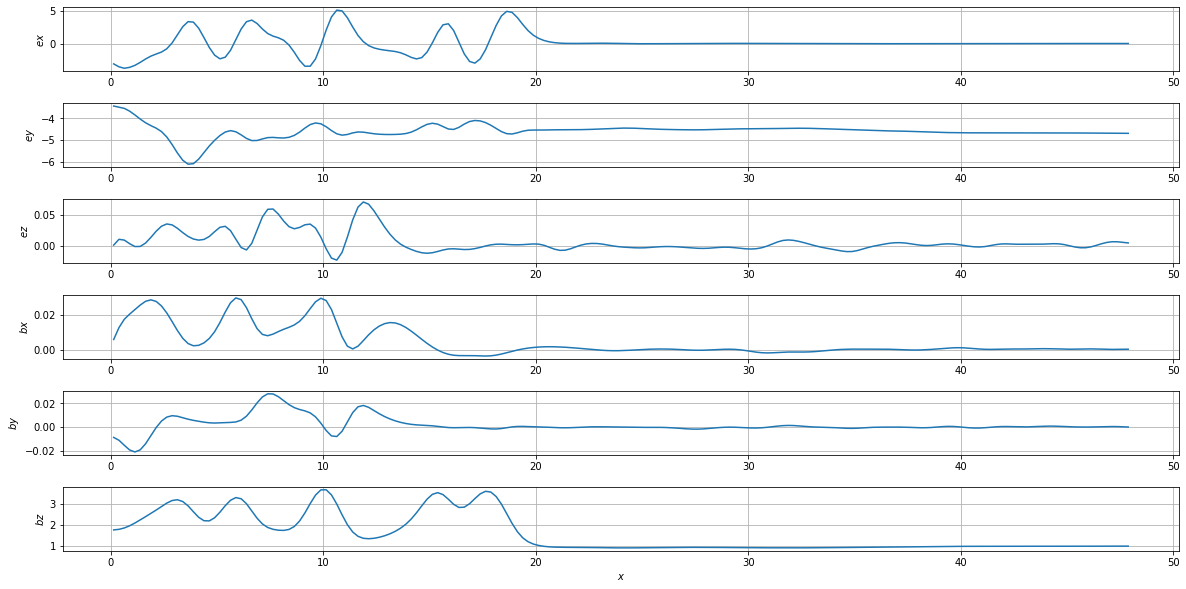

In [26]:
# (Optional) plot all the lorentz transformed fields
plt1d.plot_all_fields(dfields, axis='_xx', xxindex = 0, yyindex = 0, zzindex = 0)

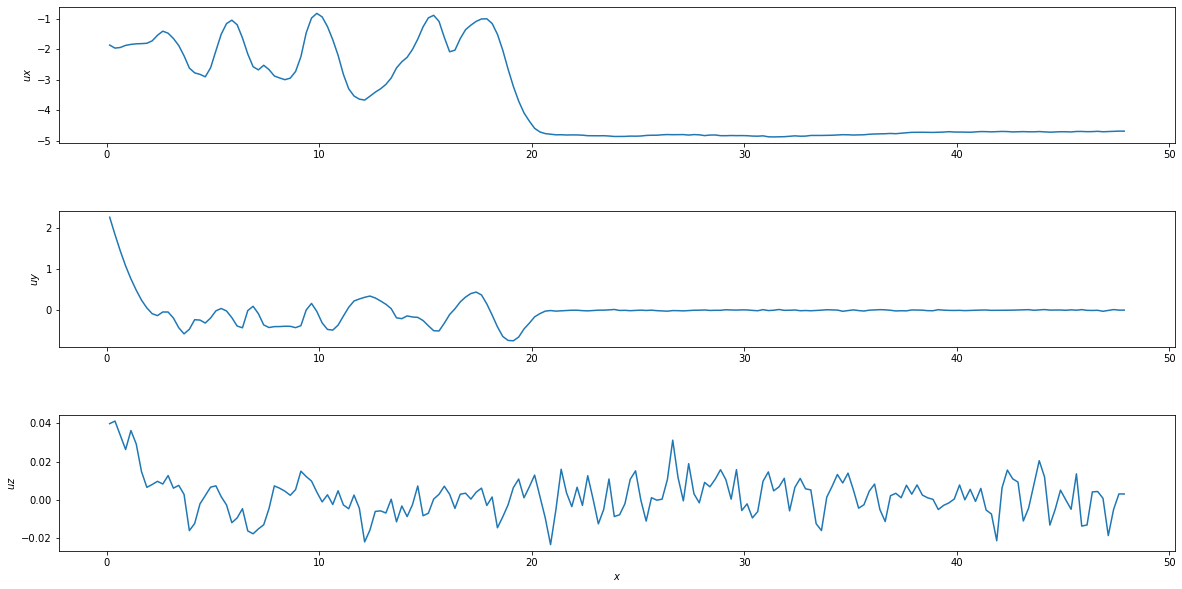

In [27]:
# (Optional) plot flow in the etimated frame of the shock
plt1d.plot_all_flow(dflow, axis='_xx', xxindex = 0, yyindex = 0, zzindex = 0)

### Load FPC data

In [28]:
ncflnm = '../M03results/m03.nc'
Hist, CEx, CEy, CEz, vx, vy, vz, x, enerCEx, enerCEy, enerCEz, Vframe_relative_to_sim, metadata_in, params_in = dnc.load3Vnetcdf4(ncflnm)

### Look for signature bounds

In [29]:
startval = 17.5#lower bound for sda metadata = 1 (di)
endval = 21.5 #upper bound for sda metadata = 1 (di)

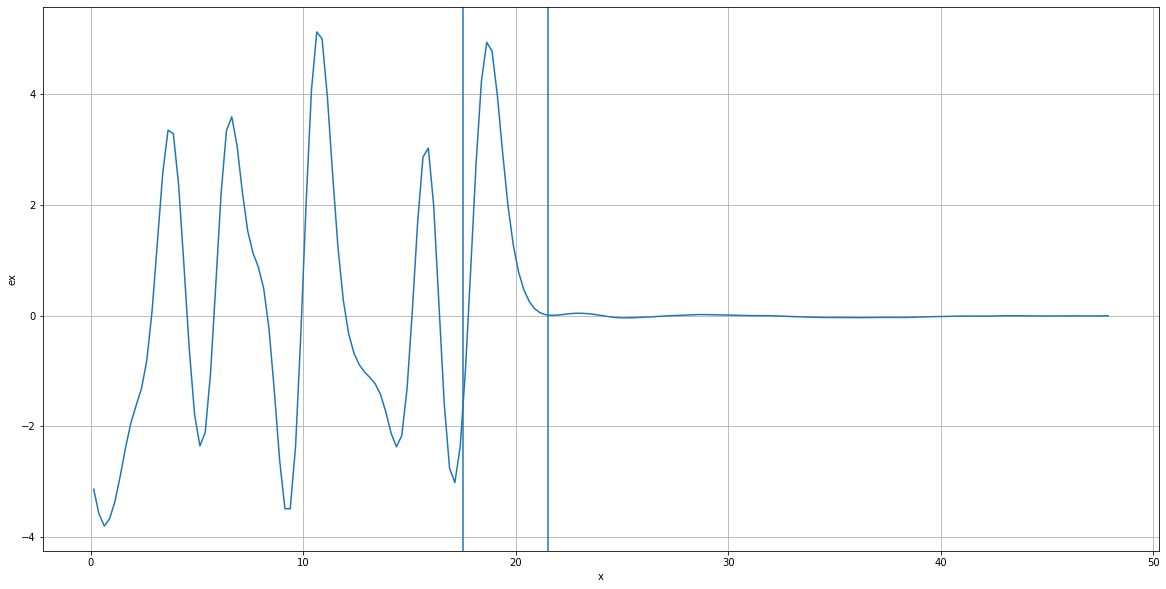

In [30]:
#option one, use Ex(x,y=0,z=0) to find SDA bounds. Should range from the start of the ramp to the first zero crossing
yyindex = 0
zzindex = 0
plt1d.plot_field(dfields, 'ex', axis='_xx', yyindex = yyindex, zzindex = zzindex, axvx1 = startval, axvx2 = endval)

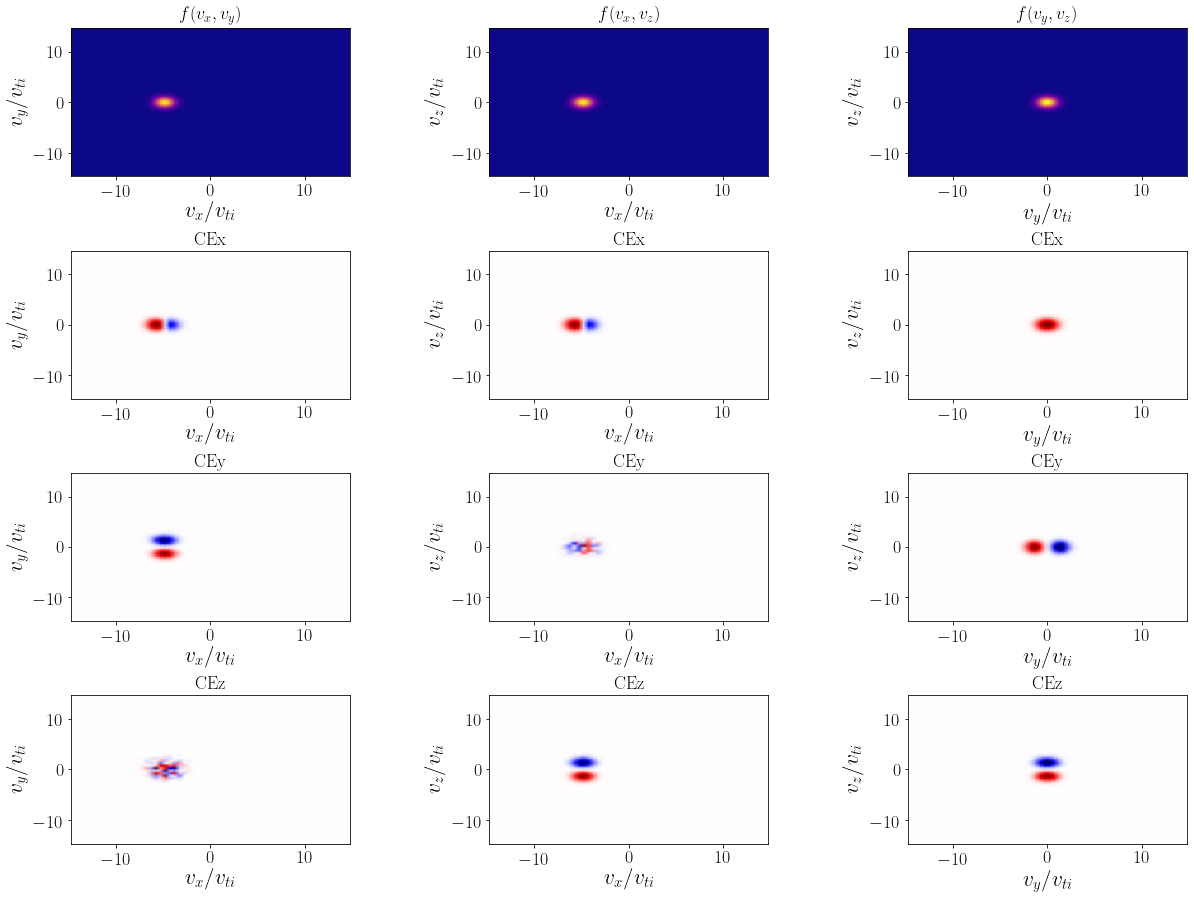

In [31]:
#option two (better but harder), look at the FPC signatures and see when the shock starts and stops

#Plot FPCs and dist funcs at start val-------------------------------------------------------------
#grab index of starval
i = ao.find_nearest(dfields['ex_xx'], startval)

#Project onto 2d axis
H_xy = ao.array_3d_to_2d(Hist[i],'xy')
H_xz = ao.array_3d_to_2d(Hist[i],'xz')
H_yz = ao.array_3d_to_2d(Hist[i],'yz')
CEx_xy = ao.array_3d_to_2d(CEx[i],'xy')
CEx_xz = ao.array_3d_to_2d(CEx[i],'xz')
CEx_yz = ao.array_3d_to_2d(CEx[i],'yz')
CEy_xy = ao.array_3d_to_2d(CEy[i],'xy')
CEy_xz = ao.array_3d_to_2d(CEy[i],'xz')
CEy_yz = ao.array_3d_to_2d(CEy[i],'yz')
CEz_xy = ao.array_3d_to_2d(CEz[i],'xy')
CEz_xz = ao.array_3d_to_2d(CEz[i],'xz')
CEz_yz = ao.array_3d_to_2d(CEz[i],'yz')

#plot
pltvv.plot_cor_and_dist_supergrid(vx, vy, vz, vmax,
                                H_xy, H_xz, H_yz,
                                CEx_xy,CEx_xz, CEx_yz,
                                CEy_xy,CEy_xz, CEy_yz,
                                CEz_xy,CEz_xz, CEz_yz)

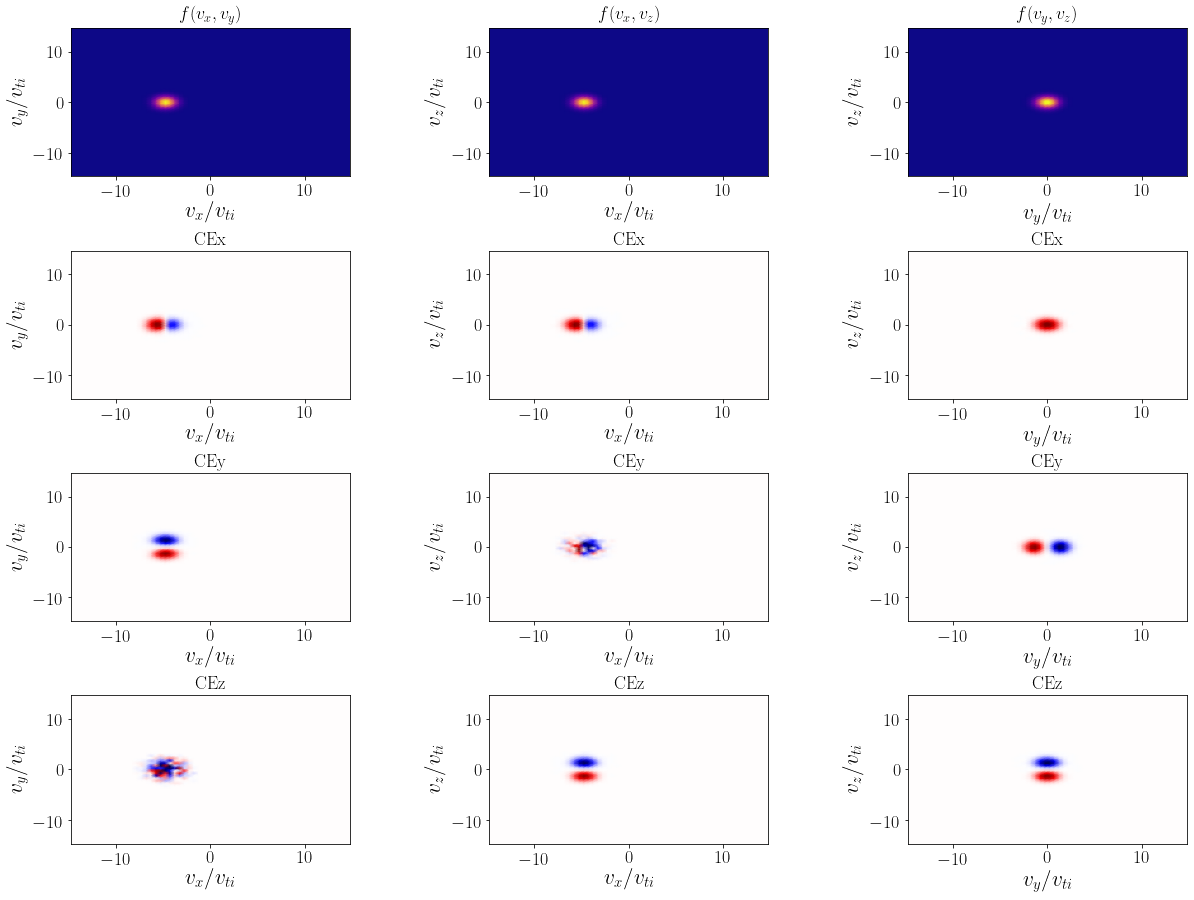

In [32]:
#Plot FPCs and dist funcs at end val--------------------------------------------------------------
#grab index of starval
i = ao.find_nearest(dfields['ex_xx'], endval)

#Project onto 2d axis
H_xy = ao.array_3d_to_2d(Hist[i],'xy')
H_xz = ao.array_3d_to_2d(Hist[i],'xz')
H_yz = ao.array_3d_to_2d(Hist[i],'yz')
CEx_xy = ao.array_3d_to_2d(CEx[i],'xy')
CEx_xz = ao.array_3d_to_2d(CEx[i],'xz')
CEx_yz = ao.array_3d_to_2d(CEx[i],'yz')
CEy_xy = ao.array_3d_to_2d(CEy[i],'xy')
CEy_xz = ao.array_3d_to_2d(CEy[i],'xz')
CEy_yz = ao.array_3d_to_2d(CEy[i],'yz')
CEz_xy = ao.array_3d_to_2d(CEz[i],'xy')
CEz_xz = ao.array_3d_to_2d(CEz[i],'xz')
CEz_yz = ao.array_3d_to_2d(CEz[i],'yz')

#plot
pltvv.plot_cor_and_dist_supergrid(vx, vy, vz, vmax,
                                H_xy, H_xz, H_yz,
                                CEx_xy,CEx_xz, CEx_yz,
                                CEy_xy,CEy_xz, CEy_yz,
                                CEz_xy,CEz_xz, CEz_yz)

In [33]:
#set metadata using add Metadata script (WIP)
cmd = 'python3 ../scripts/addMetadata.py ' + analysisflnm + ' ' + ncflnm + ' ' + str(startval) + ' ' + str(endval)
os.system(cmd+' >> temp.txt')

256

In [44]:
print(cmd)

python3 ../scripts/addMetadata.py ../analysisinputs/m03input.txt ../M03results/m03.nc 17.5 21.5


In [35]:
os.system('ls >> temp.txt')

0

### Look for shock rippling

#### Make pmesh of fields

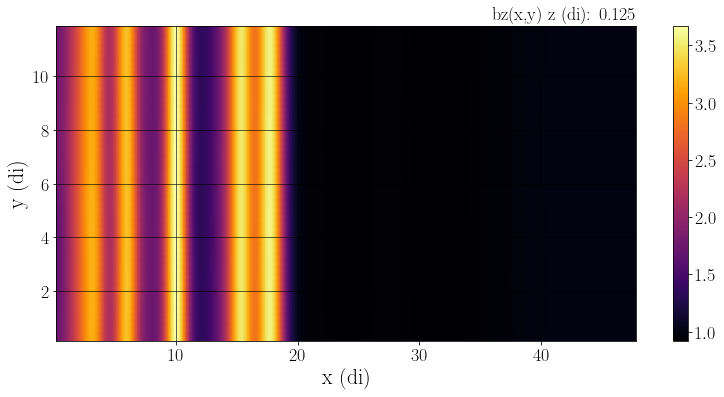

In [36]:
#plot xy plane at z=0 
plt2d.make_field_pmesh(dfields,'bz','xy',flnm = '',takeaxisaverage=False, xxindex=float('nan'), yyindex=float('nan'), zzindex=0, xlimmin=None,xlimmax=None)

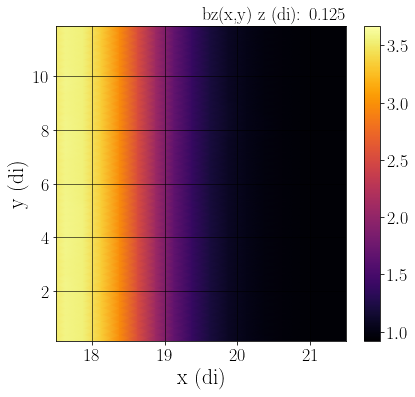

In [37]:
#zoom in on potential ripple xy plane at z=0
plt2d.make_field_pmesh(dfields,'bz','xy',flnm = '',takeaxisaverage=False, xxindex=float('nan'), yyindex=float('nan'), zzindex=0, xlimmin=startval,xlimmax=endval)

#### Make stacked line plot

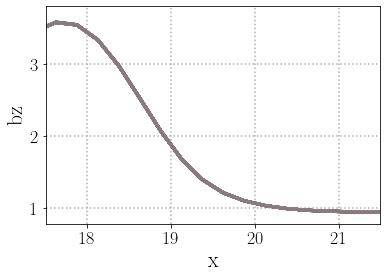

In [39]:
plt1d.plot_stack_field_along_x(dfields,'bz','_yy',yyindex=0,zzindex=0,xlow=startval,xhigh=endval)

### Diagnose corrugation instability
#### look at number of significant wave modes in fourier space
#### still WIP

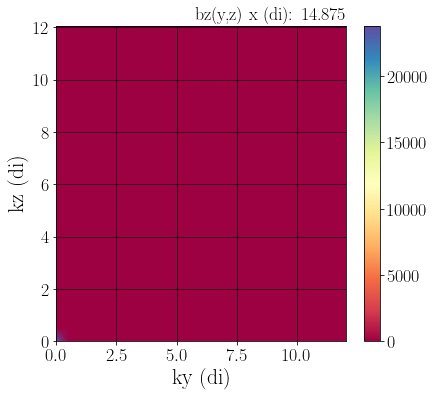

(array([  0.        ,   0.52359878,   1.04719755,   1.57079633,
          2.0943951 ,   2.61799388,   3.14159265,   3.66519143,
          4.1887902 ,   4.71238898,   5.23598776,   5.75958653,
          6.28318531,   6.80678408,   7.33038286,   7.85398163,
          8.37758041,   8.90117919,   9.42477796,   9.94837674,
         10.47197551,  10.99557429,  11.51917306,  12.04277184,
        -12.56637061, -12.04277184, -11.51917306, -10.99557429,
        -10.47197551,  -9.94837674,  -9.42477796,  -8.90117919,
         -8.37758041,  -7.85398163,  -7.33038286,  -6.80678408,
         -6.28318531,  -5.75958653,  -5.23598776,  -4.71238898,
         -4.1887902 ,  -3.66519143,  -3.14159265,  -2.61799388,
         -2.0943951 ,  -1.57079633,  -1.04719755,  -0.52359878]),
 array([  0.        ,   0.52359878,   1.04719755,   1.57079633,
          2.0943951 ,   2.61799388,   3.14159265,   3.66519143,
          4.1887902 ,   4.71238898,   5.23598776,   5.75958653,
          6.28318531,   6.80678408,   

In [42]:
shockval = 15.0 #di, some slice in the ramp of the shock
i = ao.find_nearest(dfields['ex_xx'], shockval)
pltfr.plot_fft_norm(dfields,'bz','yz',flnm = '',takeaxisaverage=False, xxindex=i, yyindex=float('nan'), zzindex=float('nan'), plotlog = False, xaxislim=None, yaxislim=None)

0